Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

Dataset loaded successfully!
  Train samples: 68,980
  Validation samples: 8,618
  Test samples: 8,427

Features: {'screen_id': Value('string'), 'question': Value('string'), 'ground_truth': List(Value('string')), 'file_name': Value('string'), 'image': Image(mode=None, decode=True)}

Sample 1:
  Q: What is the default period length?...
  A: five days
  Image size: (1080, 1920)
  Screen ID: 0
  File name: images/rico/0.jpg

Sample 2:
  Q: What is the default cycle length?...
  A: 30
  Image size: (1080, 1920)
  Screen ID: 0
  File name: images/rico/0.jpg

Sample 3:
  Q: What is the start date of the last period?...
  A: Feb 10, 2017
  Image size: (1080, 1920)
  Screen ID: 0
  File name: images/rico/0.jpg


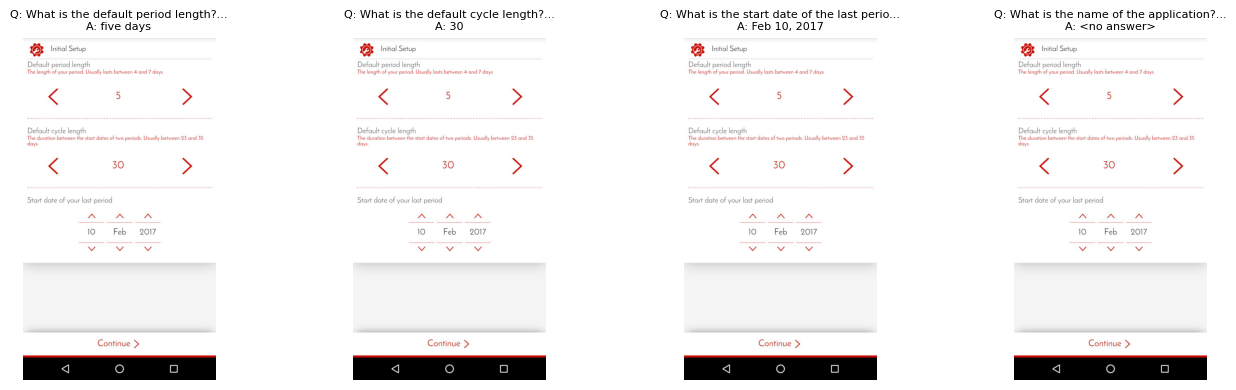

In [ ]:
# BLOCK 1: LOAD DATASET AND SAMPLE CHECKING

from datasets import load_from_disk
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Load dataset from disk
dataset = load_from_disk("/content/hf_datasets/RICO-ScreenQA-Short")

print(f"Dataset loaded successfully!")
print(f"  Train samples: {len(dataset['train']):,}")
print(f"  Validation samples: {len(dataset['validation']):,}")
print(f"  Test samples: {len(dataset['test']):,}")
print(f"\nFeatures: {dataset['train'].features}")

# Preview samples
for i in range(3):
    s = dataset['train'][i]
    print(f"\nSample {i+1}:")
    print(f"  Q: {s['question'][:60]}...")
    print(f"  A: {s['ground_truth'][0]}")
    print(f"  Image size: {s['image'].size}")
    print(f"  Screen ID: {s['screen_id']}")
    print(f"  File name: {s['file_name']}")

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
for i, ax in enumerate(axes):
    s = dataset['train'][i]
    ax.imshow(s['image'])
    ax.set_title(f"Q: {s['question'][:40]}...\nA: {s['ground_truth'][0][:15]}", fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.savefig('/content/samples.png', dpi=150)
plt.show()

In [ ]:
# BLOCK 2: INSTALL, IMPORTS & SETUP FOR PIX2STRUCT

!pip install -q transformers accelerate sentencepiece

import torch
import gc
from torch.utils.data import Dataset, DataLoader
from transformers import Pix2StructProcessor, Pix2StructForConditionalGeneration
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
import os

gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA GeForce RTX 4070


In [ ]:
# BLOCK 3: CONFIG

class Config:
    MODEL_NAME = "google/pix2struct-docvqa-base"
    MAX_PATCHES = 512
    MAX_LENGTH = 20
    BATCH_SIZE = 1
    GRAD_ACCUM = 16
    EPOCHS = 1
    LR = 2e-5
    TRAIN_SAMPLES = 10000  # Subset
    OUTPUT_DIR = "/content/pix2struct_output"

config = Config()
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

In [ ]:
# BLOCK 4: LOAD MODEL

processor = Pix2StructProcessor.from_pretrained(config.MODEL_NAME)

# Load in FP32 (required for gradient scaling)
model = Pix2StructForConditionalGeneration.from_pretrained(config.MODEL_NAME)
model = model.to(device)

print(f"  VRAM: {torch.cuda.memory_allocated()/1e9:.2f} GB")

  VRAM: 1.13 GB


In [ ]:
# BLOCK 5: DATASET CLASS

class LightweightDataset(Dataset):
    def __init__(self, hf_dataset, processor, max_patches, max_length, max_samples=None):
        if max_samples:
            self.dataset = hf_dataset.select(range(min(max_samples, len(hf_dataset))))
        else:
            self.dataset = hf_dataset
        self.processor = processor
        self.max_patches = max_patches
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]

        image = sample['image']
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Resize to save memory
        max_size = 800
        if max(image.size) > max_size:
            ratio = max_size / max(image.size)
            new_size = (int(image.size[0] * ratio), int(image.size[1] * ratio))
            image = image.resize(new_size, Image.LANCZOS)

        question = sample['question']
        answer = sample['ground_truth'][0]

        encoding = self.processor(
            images=image,
            text=question,
            return_tensors="pt",
            max_patches=self.max_patches,
        )

        encoding = {k: v.squeeze(0) for k, v in encoding.items()}

        labels = self.processor.tokenizer(
            answer,
            return_tensors="pt",
            padding="max_length",
            max_length=self.max_length,
            truncation=True
        ).input_ids.squeeze(0)

        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        encoding["labels"] = labels

        return encoding

# CREATE DATASETS
train_dataset = LightweightDataset(
    dataset['train'], processor,
    config.MAX_PATCHES, config.MAX_LENGTH,
    max_samples=config.TRAIN_SAMPLES
)
val_dataset = LightweightDataset(
    dataset['validation'], processor,
    config.MAX_PATCHES, config.MAX_LENGTH,
    max_samples=1000  # Smaller val set
)

print(f"Train: {len(train_dataset)}")
print(f"Val: {len(val_dataset)}")

Train: 10000
Val: 1000


In [ ]:
# BLOCK 6: COLLATE FUNCTION

def collate_fn(batch):
    max_patches = max(item['flattened_patches'].shape[0] for item in batch)

    padded_patches = []
    attention_masks = []
    labels_list = []

    for item in batch:
        patches = item['flattened_patches']
        mask = item['attention_mask']

        pad_len = max_patches - patches.shape[0]
        if pad_len > 0:
            patches = torch.cat([patches, torch.zeros(pad_len, patches.shape[1])])
            mask = torch.cat([mask, torch.zeros(pad_len)])

        padded_patches.append(patches)
        attention_masks.append(mask)
        labels_list.append(item['labels'])

    return {
        'flattened_patches': torch.stack(padded_patches),
        'attention_mask': torch.stack(attention_masks),
        'labels': torch.stack(labels_list)
    }

In [ ]:
# BLOCK 7: TRAINING

from torch.optim import AdamW

train_loader = DataLoader(
    train_dataset, batch_size=config.BATCH_SIZE,
    shuffle=True, num_workers=0, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=config.BATCH_SIZE,
    shuffle=False, num_workers=0, collate_fn=collate_fn
)

optimizer = AdamW(model.parameters(), lr=config.LR, weight_decay=0.01)

total_steps = len(train_loader) * config.EPOCHS // config.GRAD_ACCUM
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, total_steps)

best_val_loss = float('inf')

for epoch in range(config.EPOCHS):
    print(f"\n")
    print(f"EPOCH {epoch+1}/{config.EPOCHS}")


    # TRAIN
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    pbar = tqdm(train_loader, desc="Training")
    for step, batch in enumerate(pbar):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss / config.GRAD_ACCUM
        loss.backward()

        if (step + 1) % config.GRAD_ACCUM == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * config.GRAD_ACCUM

        if step % 50 == 0:
            torch.cuda.empty_cache()

        pbar.set_postfix({
            'loss': f'{loss.item() * config.GRAD_ACCUM:.4f}',
            'VRAM': f'{torch.cuda.memory_allocated()/1e9:.1f}GB'
        })

    avg_train_loss = total_loss / len(train_loader)

    # VALIDATE
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f"\nTrain Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"{config.OUTPUT_DIR}/best_model.pt")
        print(f"Best model saved")

    gc.collect()
    torch.cuda.empty_cache()



EPOCH 1/1


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Validating:   0%|          | 0/1000 [00:00<?, ?it/s]


Train Loss: 1.4074 | Val Loss: 1.0897
Best model saved



Evaluating Train (100 samples)...


  0%|          | 0/100 [00:00<?, ?it/s]

  Train Accuracy: 0.4300 (43.00%)
  Correct: 43/100

Evaluating Validation (100 samples)...


  0%|          | 0/100 [00:00<?, ?it/s]

  Validation Accuracy: 0.2300 (23.00%)
  Correct: 23/100

Evaluating Test (100 samples)...


  0%|          | 0/100 [00:00<?, ?it/s]

  Test Accuracy: 0.4200 (42.00%)
  Correct: 42/100
ACCURACY SUMMARY
  Train Accuracy:      0.4300 (43.00%)
  Validation Accuracy: 0.2300 (23.00%)
  Test Accuracy:       0.4200 (42.00%)


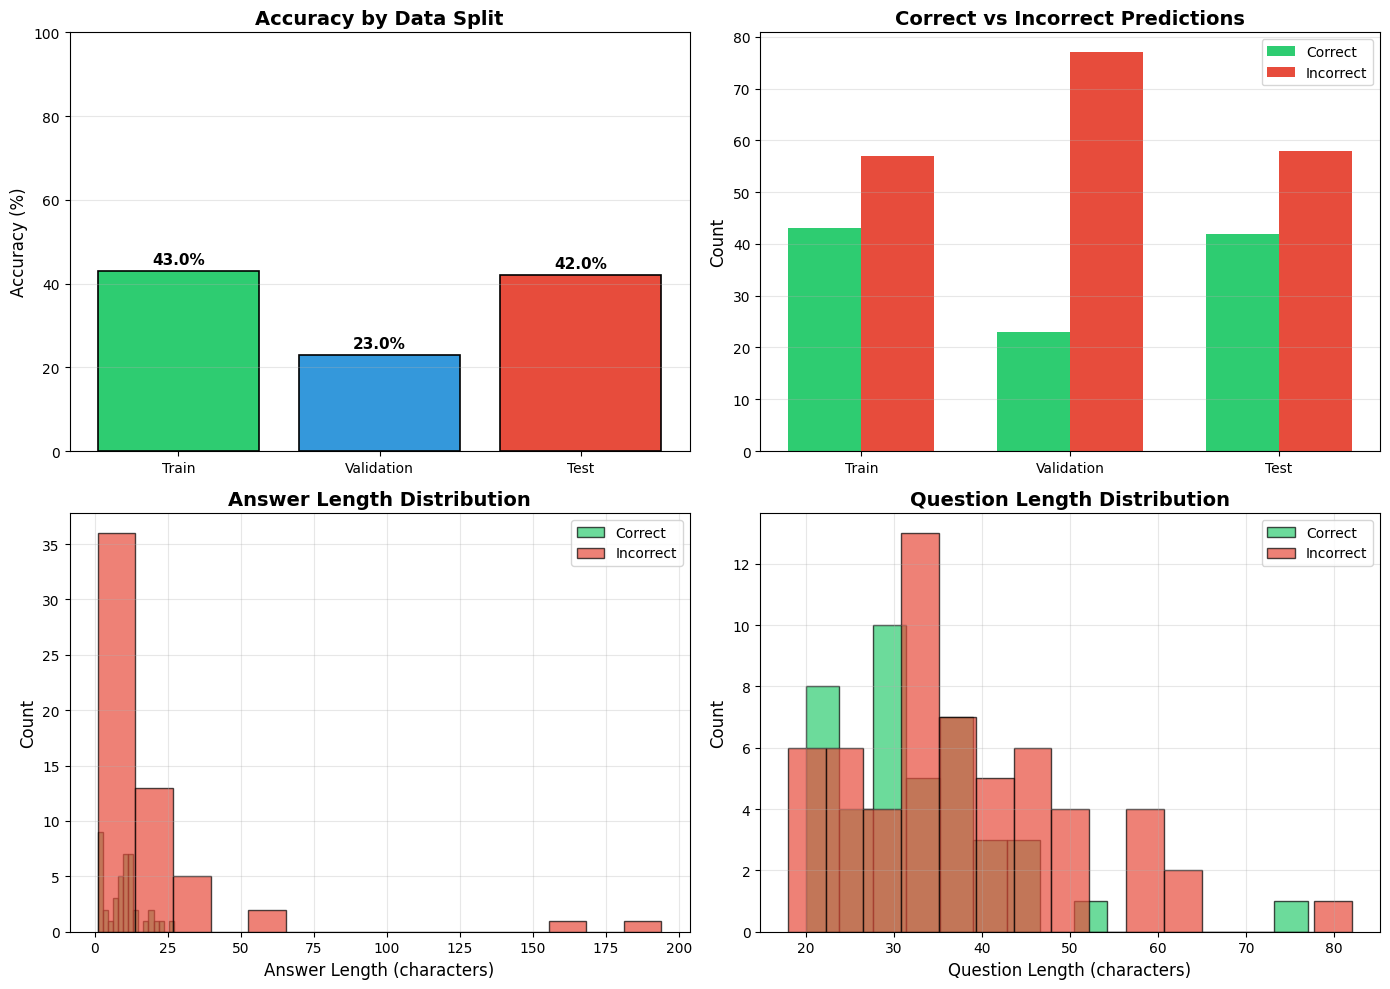

CORRECT PREDICTIONS WITH IMAGES (Test Set)
Total correct: 42


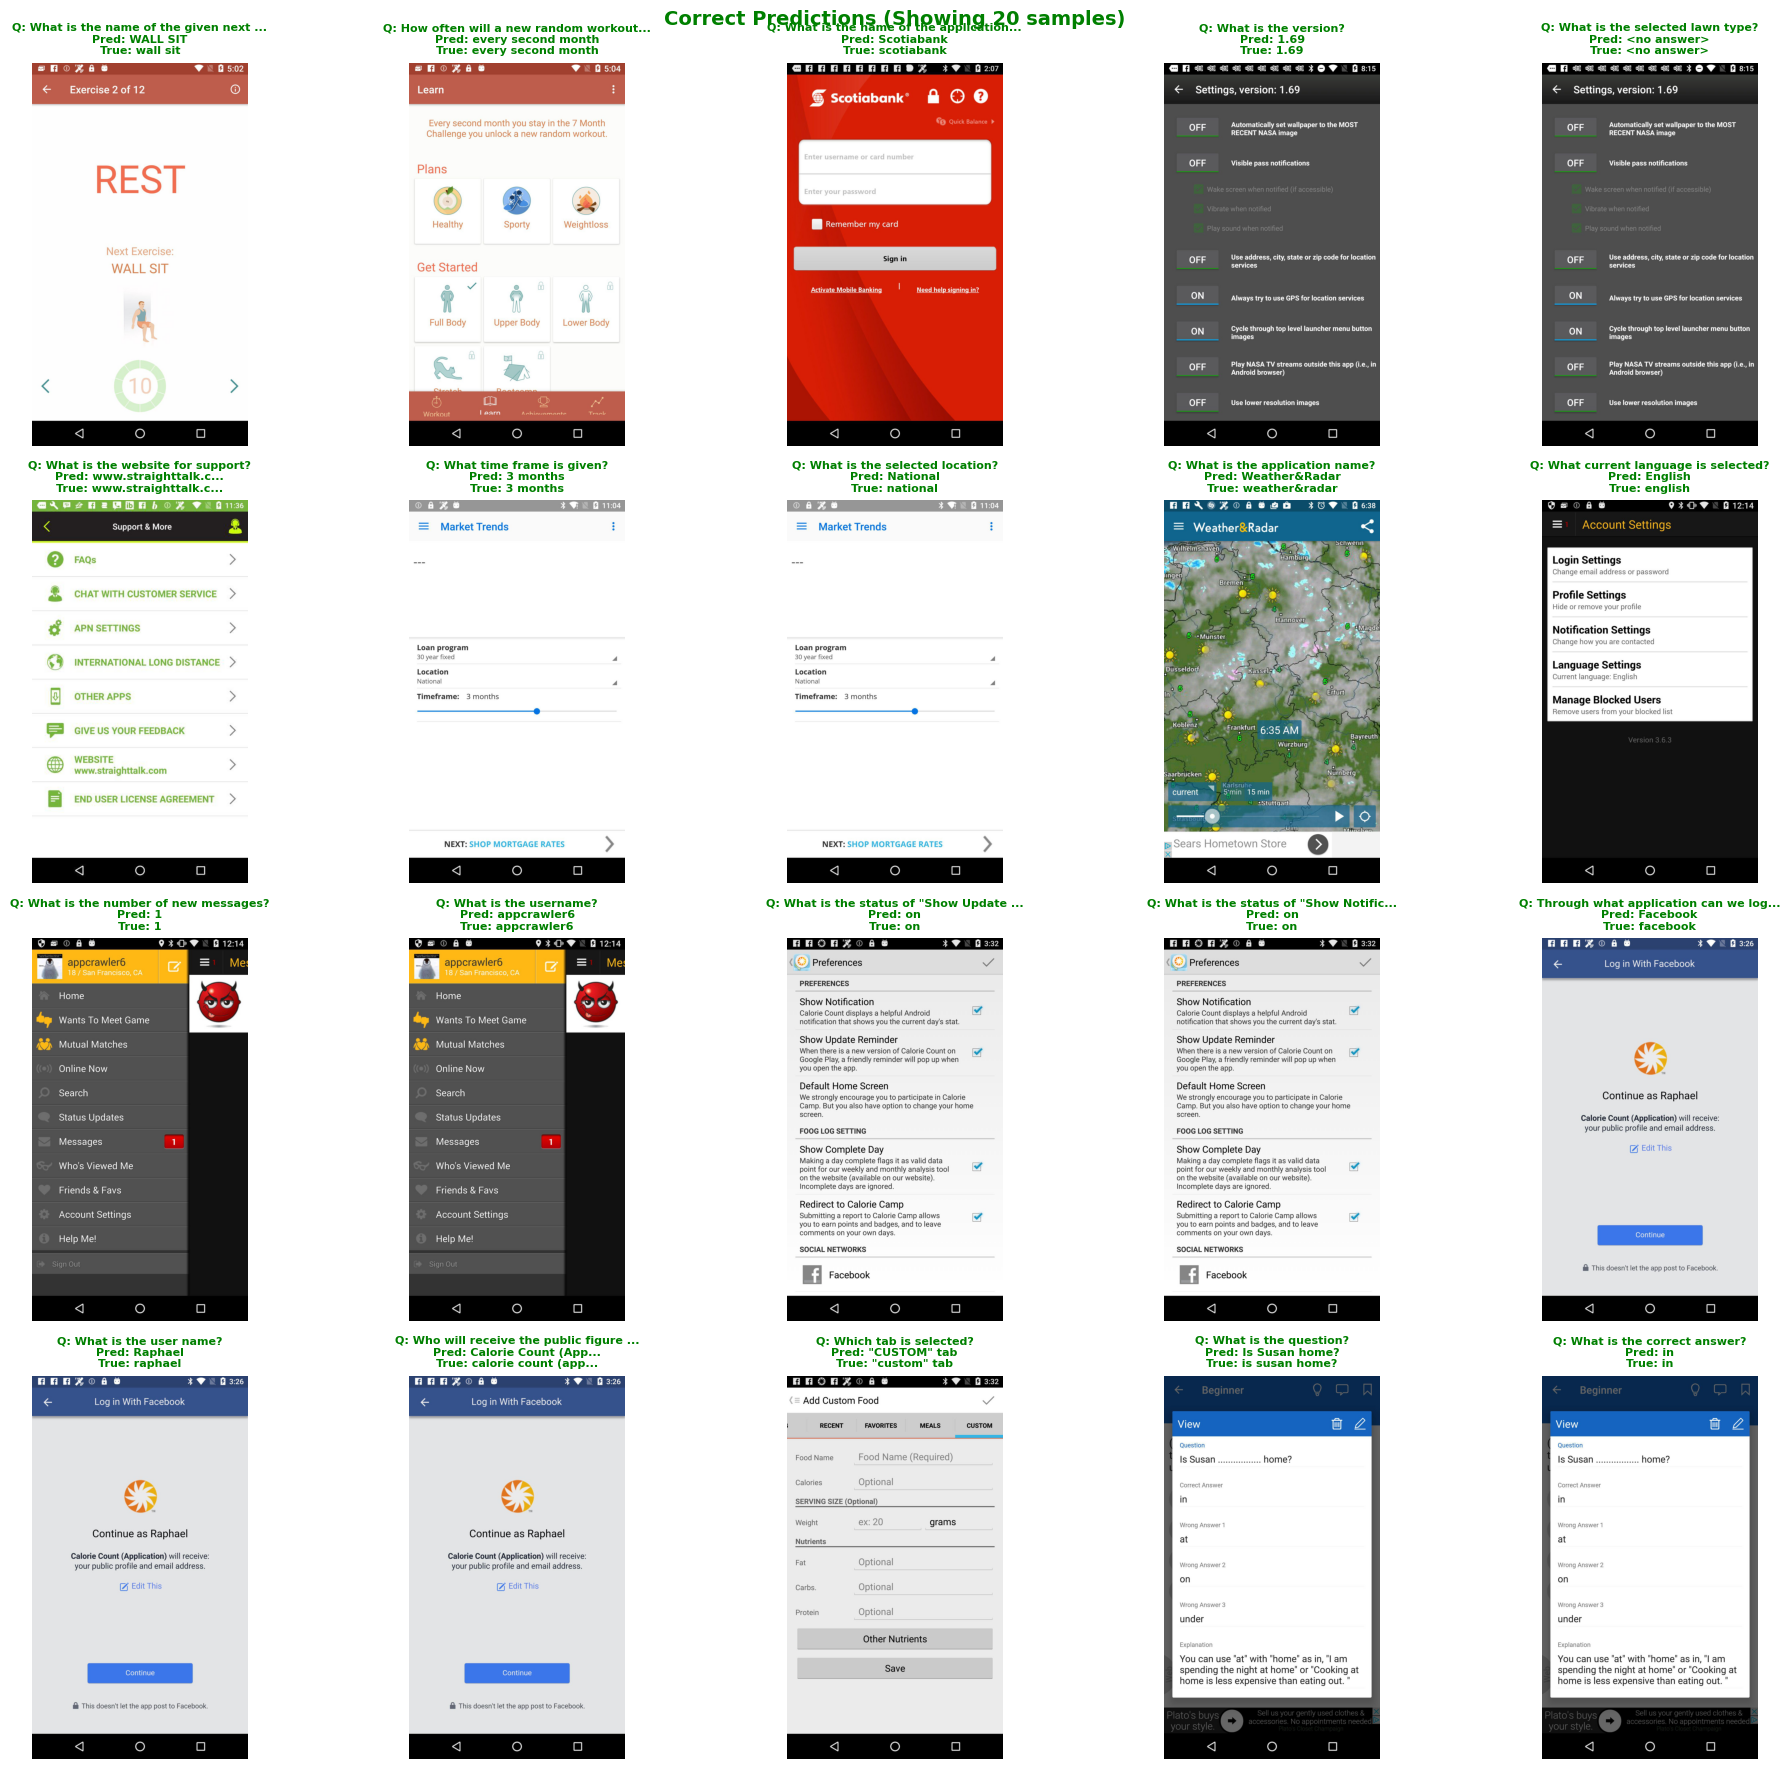

Saved to /content/correct_predictions.png

--- More Correct Predictions ---


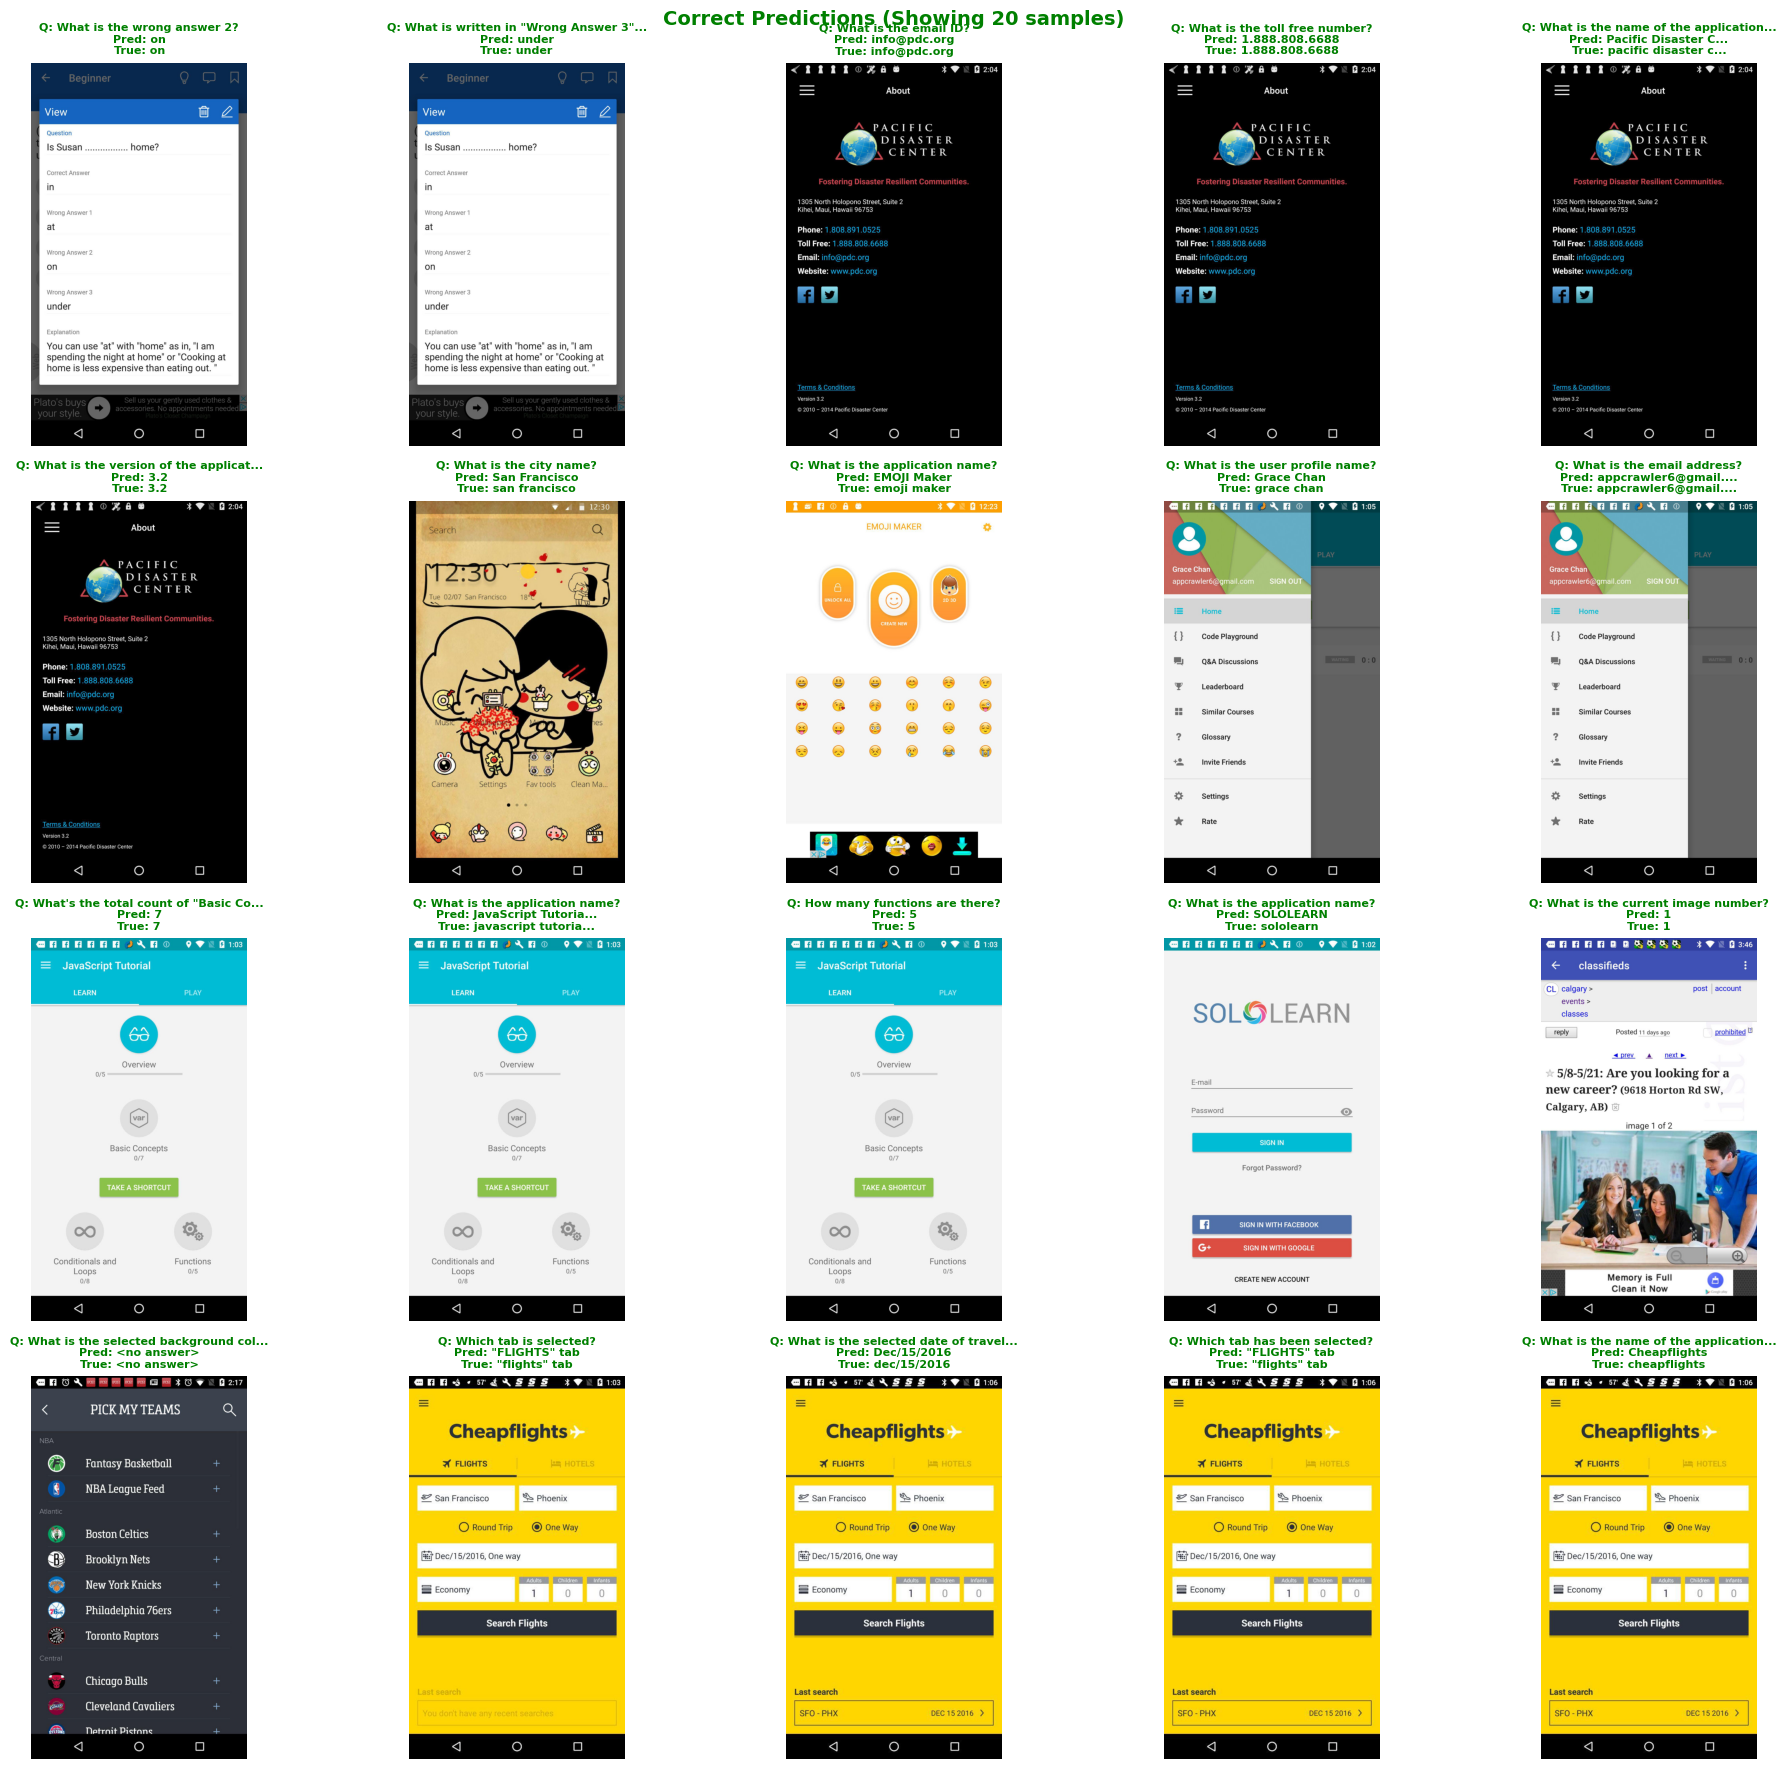

Saved to /content/correct_predictions.png
INCORRECT PREDICTIONS WITH IMAGES (Test Set)
Total incorrect: 58


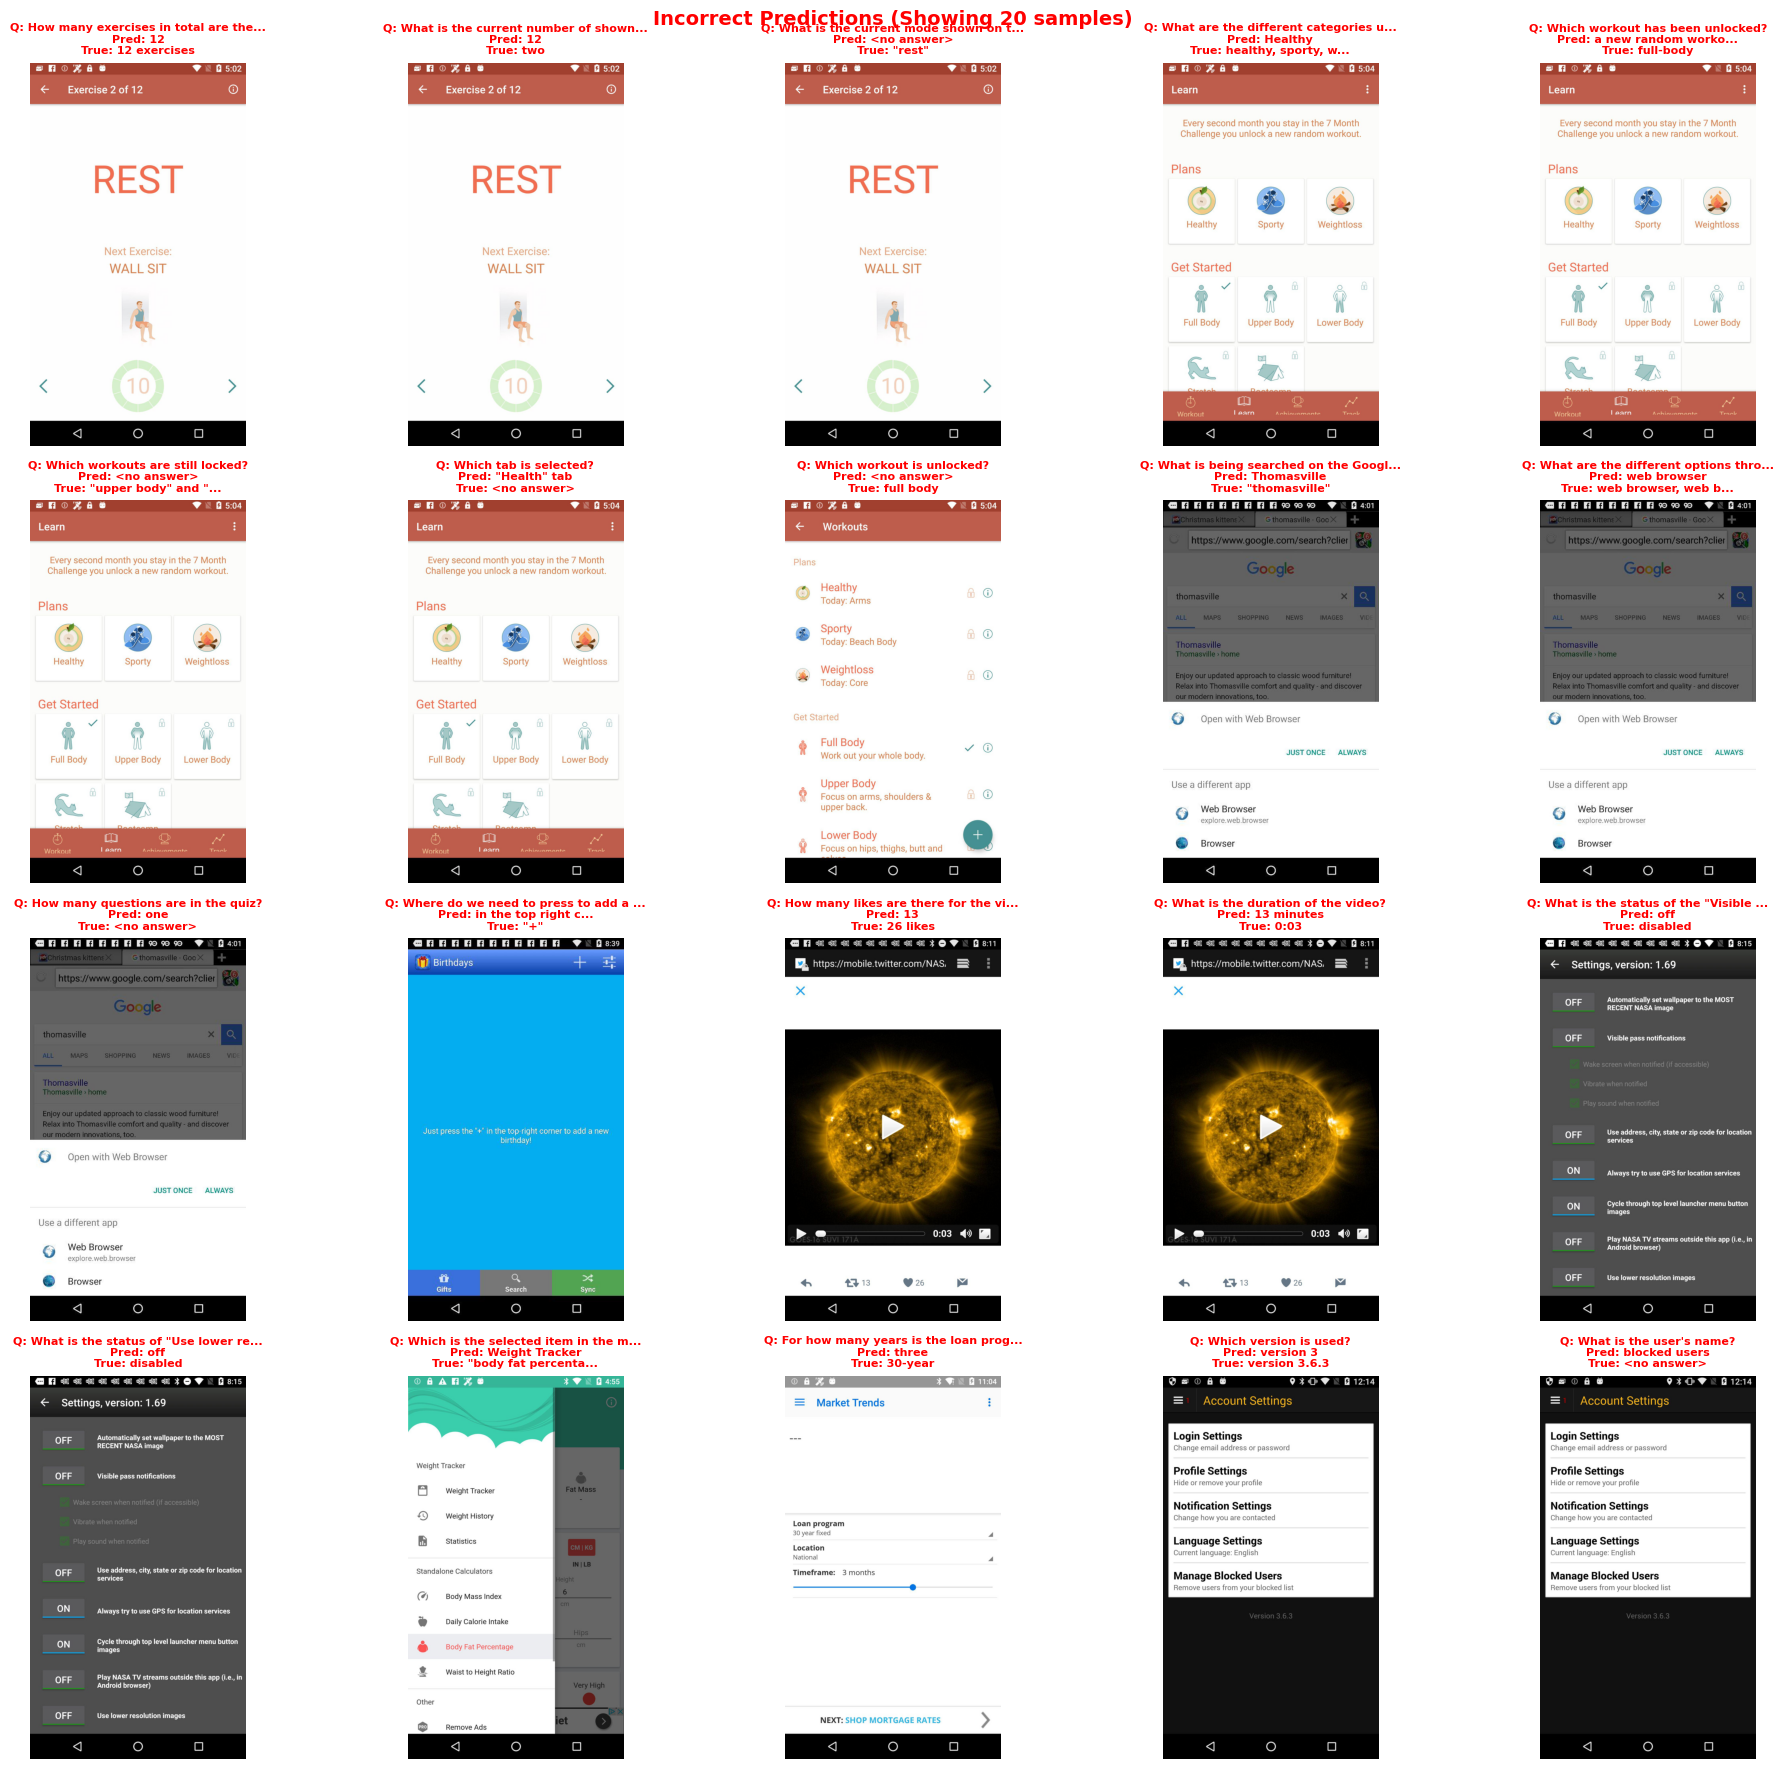

Saved to /content/incorrect_predictions.png

--- More Incorrect Predictions ---


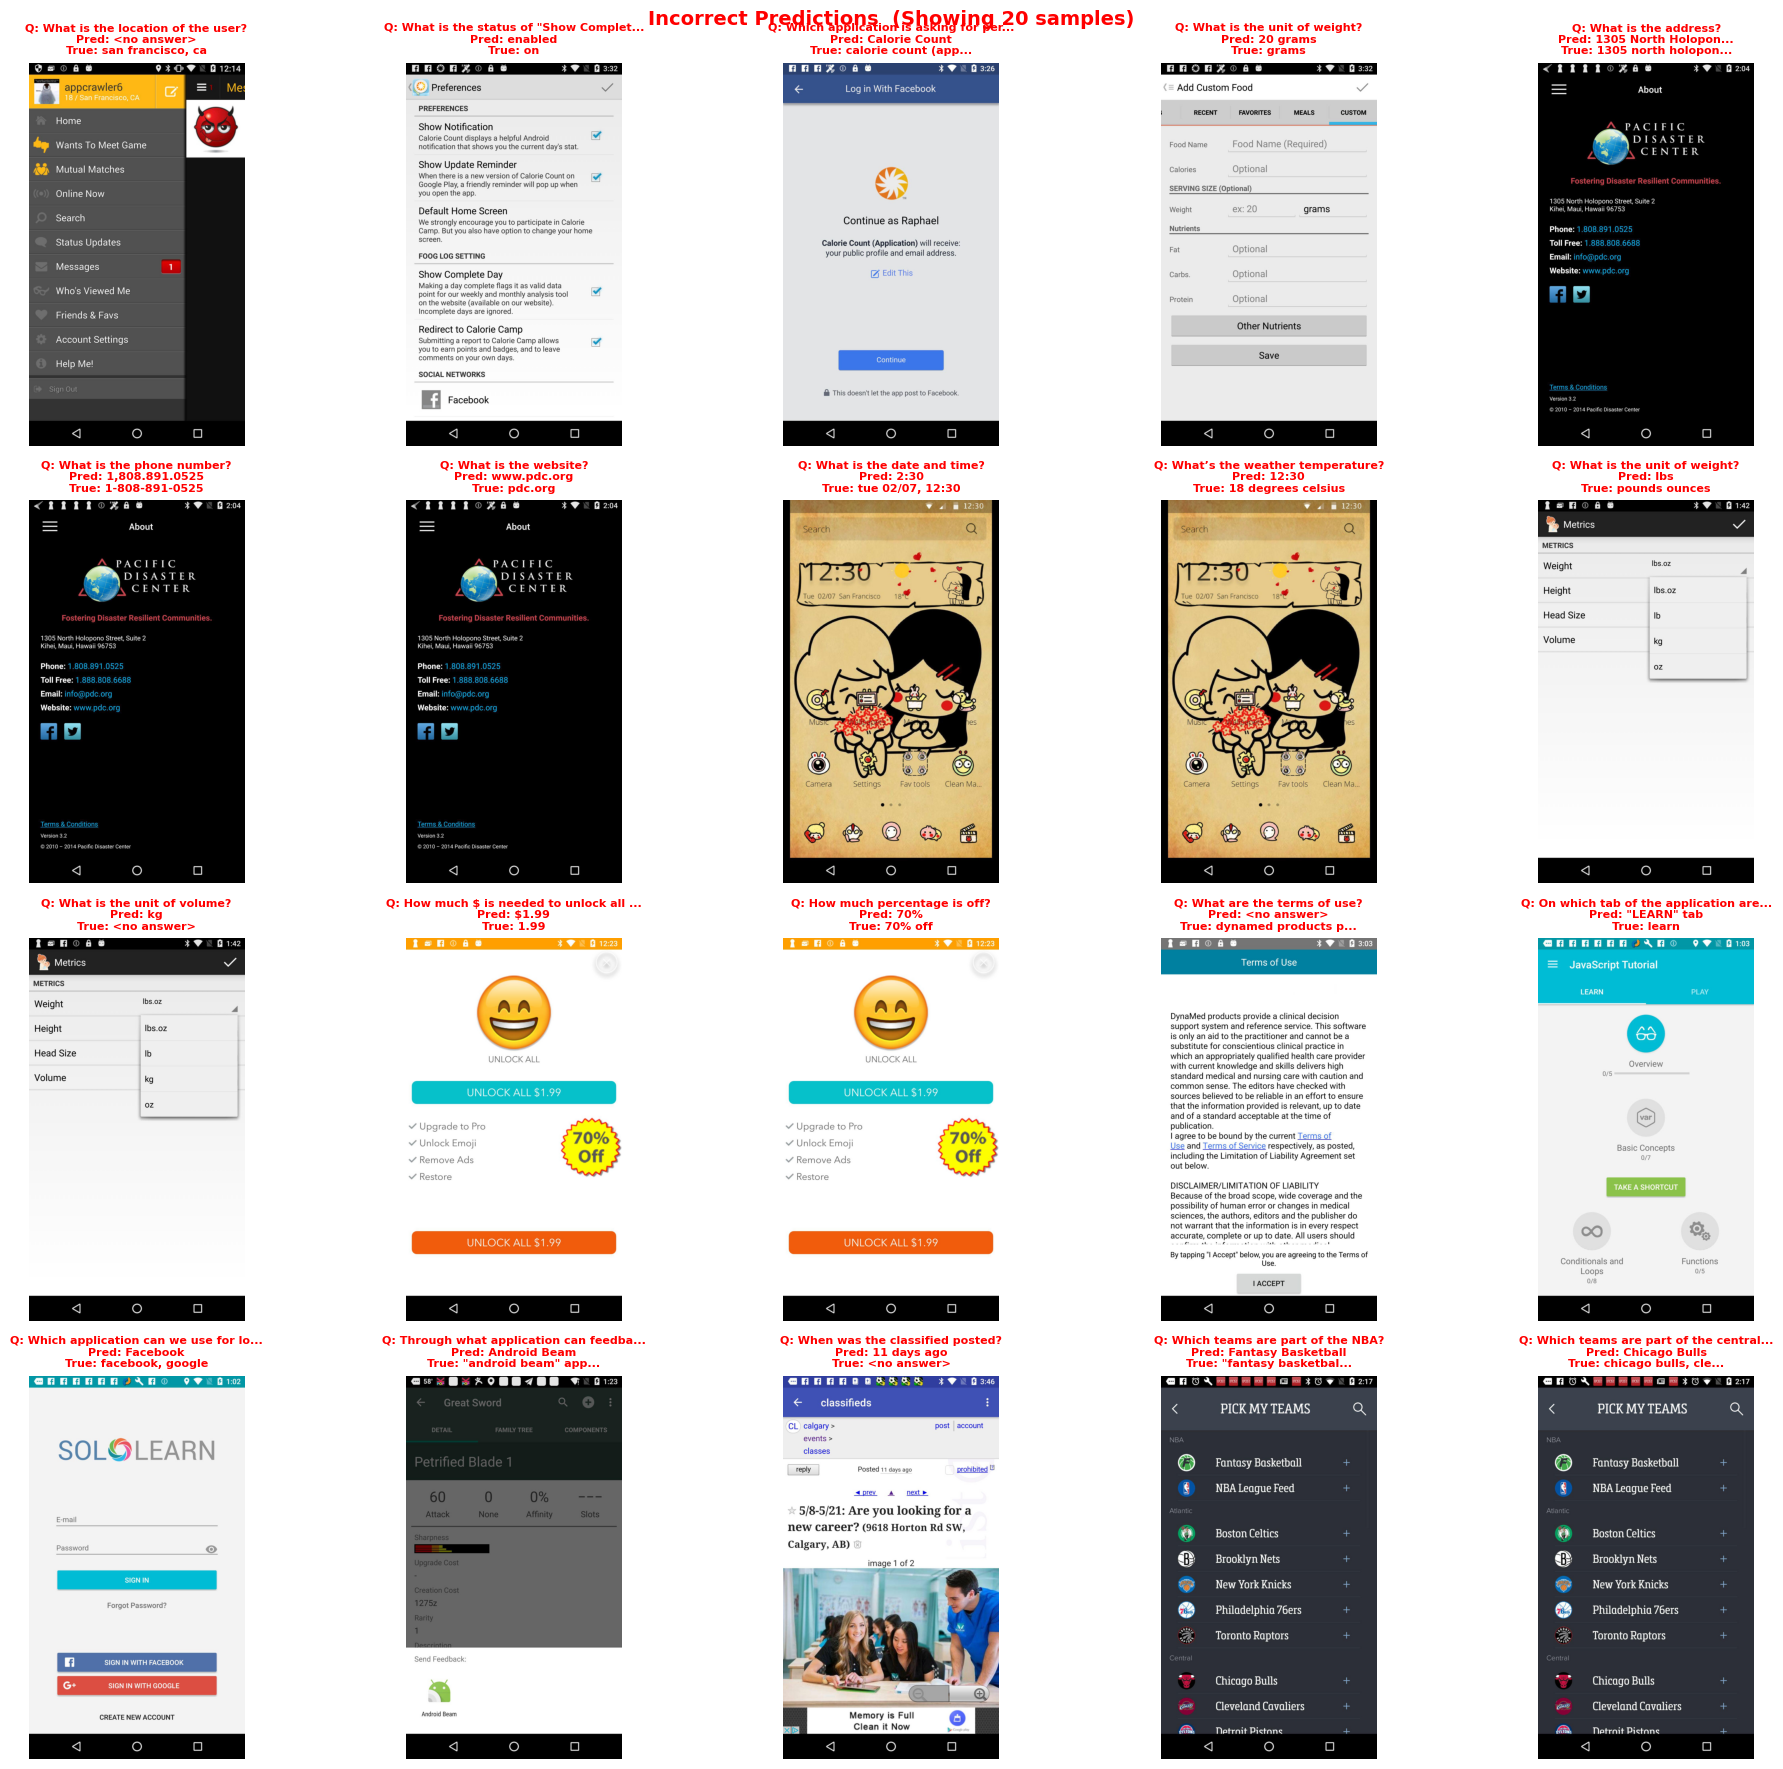

Saved to /content/incorrect_predictions_.png
SIDE-BY-SIDE: CORRECT vs INCORRECT


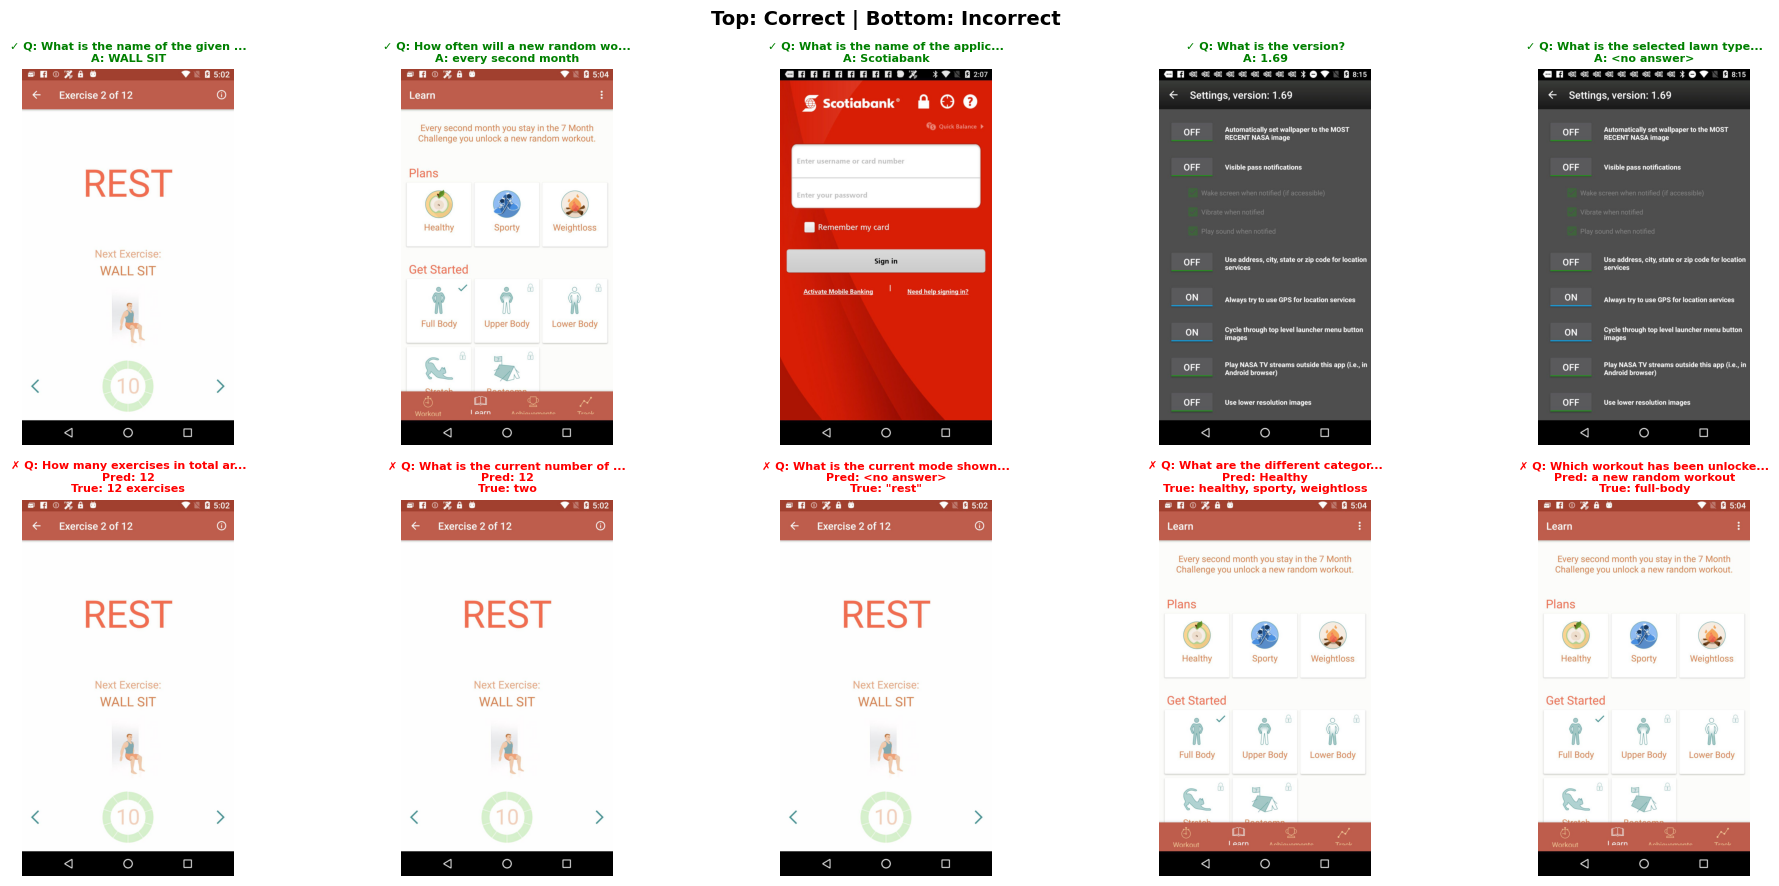

SAMPLE CORRECT PREDICTIONS (Text)
#     QUESTION                                           ANSWER                        
1     What is the name of the given next exercise?       WALL SIT                      
2     How often will a new random workout be unlocked... every second month            
3     What is the name of the application?               Scotiabank                    
4     What is the version?                               1.69                          
5     What is the selected lawn type?                    <no answer>                   
6     What is the website for support?                   www.straighttalk.com          
7     What time frame is given?                          3 months                      
8     What is the selected location?                     National                      
9     What is the application name?                      Weather&Radar                 
10    What current language is selected?                 English                      

In [ ]:
# BLOCK 8: EVALUATION & GRAPHS WITH SAMPLE IMAGES

import matplotlib.pyplot as plt
from collections import Counter

# Load best model
model.load_state_dict(torch.load(f"{config.OUTPUT_DIR}/best_model.pt"))
model.eval()

def generate_answer(image, question):
    if image.mode != 'RGB':
        image = image.convert('RGB')

    max_size = 800
    if max(image.size) > max_size:
        ratio = max_size / max(image.size)
        new_size = (int(image.size[0] * ratio), int(image.size[1] * ratio))
        image = image.resize(new_size, Image.LANCZOS)

    inputs = processor(
        images=image,
        text=question,
        return_tensors="pt",
        max_patches=config.MAX_PATCHES
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=config.MAX_LENGTH,
            num_beams=2,
            early_stopping=True
        )

    return processor.decode(generated_ids[0], skip_special_tokens=True).strip()

def evaluate_accuracy(data_split, split_name, num_samples=100):
    print(f"\nEvaluating {split_name} ({num_samples} samples)...")

    correct = 0
    total = 0
    results = []

    for i in tqdm(range(min(num_samples, len(data_split)))):
        sample = data_split[i]

        try:
            pred = generate_answer(sample['image'], sample['question'])
        except:
            pred = ""

        true_ans = sample['ground_truth'][0].strip().lower()
        pred_lower = pred.strip().lower()
        is_correct = pred_lower == true_ans

        if is_correct:
            correct += 1
        total += 1

        results.append({
            'idx': i,  # Store index to retrieve image later
            'question': sample['question'],
            'predicted': pred,
            'ground_truth': true_ans,
            'correct': is_correct
        })

        if i % 100 == 0:
            torch.cuda.empty_cache()

    accuracy = correct / total
    print(f"  {split_name} Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Correct: {correct}/{total}")

    return accuracy, results

# EVALUATE ALL SPLITS
train_acc, train_results = evaluate_accuracy(dataset['train'], "Train", num_samples=100)
val_acc, val_results = evaluate_accuracy(dataset['validation'], "Validation", num_samples=100)
test_acc, test_results = evaluate_accuracy(dataset['test'], "Test", num_samples=100)



print("ACCURACY SUMMARY")
print(f"  Train Accuracy:      {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"  Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"  Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")

# PLOT ACCURACY GRAPHS
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Accuracy Comparison Bar Chart
ax1 = axes[0, 0]
splits = ['Train', 'Validation', 'Test']
accuracies = [train_acc * 100, val_acc * 100, test_acc * 100]
colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax1.bar(splits, accuracies, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Accuracy by Data Split', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)

for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Correct vs Incorrect
ax2 = axes[0, 1]
correct_counts = [
    sum(r['correct'] for r in train_results),
    sum(r['correct'] for r in val_results),
    sum(r['correct'] for r in test_results)
]
incorrect_counts = [
    len(train_results) - correct_counts[0],
    len(val_results) - correct_counts[1],
    len(test_results) - correct_counts[2]
]

x = np.arange(3)
width = 0.35
bars1 = ax2.bar(x - width/2, correct_counts, width, label='Correct', color='#2ecc71')
bars2 = ax2.bar(x + width/2, incorrect_counts, width, label='Incorrect', color='#e74c3c')
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Correct vs Incorrect Predictions', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(splits)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Answer Length Distribution
ax3 = axes[1, 0]
correct_lens = [len(r['ground_truth']) for r in test_results if r['correct']]
incorrect_lens = [len(r['ground_truth']) for r in test_results if not r['correct']]

ax3.hist(correct_lens, bins=15, alpha=0.7, label='Correct', color='#2ecc71', edgecolor='black')
ax3.hist(incorrect_lens, bins=15, alpha=0.7, label='Incorrect', color='#e74c3c', edgecolor='black')
ax3.set_xlabel('Answer Length (characters)', fontsize=12)
ax3.set_ylabel('Count', fontsize=12)
ax3.set_title('Answer Length Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Question Length Distribution
ax4 = axes[1, 1]
correct_q_lens = [len(r['question']) for r in test_results if r['correct']]
incorrect_q_lens = [len(r['question']) for r in test_results if not r['correct']]

ax4.hist(correct_q_lens, bins=15, alpha=0.7, label='Correct', color='#2ecc71', edgecolor='black')
ax4.hist(incorrect_q_lens, bins=15, alpha=0.7, label='Incorrect', color='#e74c3c', edgecolor='black')
ax4.set_xlabel('Question Length (characters)', fontsize=12)
ax4.set_ylabel('Count', fontsize=12)
ax4.set_title('Question Length Distribution', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/accuracy_graphs.png', dpi=150, bbox_inches='tight')
plt.show()

# SAMPLE IMAGES FUNCTION
def show_sample_images(results_list, data_split, title, color, num_samples=20):
    n = min(num_samples, len(results_list))
    if n == 0:
        print(f"No samples to show for {title}")
        return

    cols = 5
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(20, 4.5 * rows))
    axes = axes.flatten() if rows > 1 else (axes if isinstance(axes, np.ndarray) else [axes])

    for i in range(rows * cols):
        ax = axes[i]
        if i < n:
            r = results_list[i]
            sample = data_split[r['idx']]

            ax.imshow(sample['image'])

            q = r['question'][:35] + '...' if len(r['question']) > 35 else r['question']
            pred = r['predicted'][:18] + '...' if len(r['predicted']) > 18 else r['predicted']
            true = r['ground_truth'][:18] + '...' if len(r['ground_truth']) > 18 else r['ground_truth']

            title_text = f"Q: {q}\nPred: {pred}\nTrue: {true}"
            ax.set_title(title_text, fontsize=8, color=color, fontweight='bold')
        ax.axis('off')

    plt.suptitle(f"{title} (Showing {n} samples)", fontsize=14, fontweight='bold', color=color)
    plt.tight_layout()
    filename = f'/content/{title.lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved to {filename}")

# SHOW CORRECT PREDICTIONS WITH IMAGES
print("CORRECT PREDICTIONS WITH IMAGES (Test Set)")

correct_results = [r for r in test_results if r['correct']]
print(f"Total correct: {len(correct_results)}")

# Show first 20 correct
show_sample_images(correct_results, dataset['test'], "Correct Predictions", "green", num_samples=20)

# Show next 20 correct (if available)
if len(correct_results) > 20:
    print("\n--- More Correct Predictions ---")
    show_sample_images(correct_results[20:], dataset['test'], "Correct Predictions", "green", num_samples=20)

# SHOW INCORRECT PREDICTIONS WITH IMAGES
print("INCORRECT PREDICTIONS WITH IMAGES (Test Set)")

incorrect_results = [r for r in test_results if not r['correct']]
print(f"Total incorrect: {len(incorrect_results)}")

# Show first 20 incorrect
show_sample_images(incorrect_results, dataset['test'], "Incorrect Predictions", "red", num_samples=20)

# Show next 20 incorrect (if available)
if len(incorrect_results) > 20:
    print("\n--- More Incorrect Predictions ---")
    show_sample_images(incorrect_results[20:], dataset['test'], "Incorrect Predictions ", "red", num_samples=20)

# SIDE-BY-SIDE COMPARISON
print("SIDE-BY-SIDE: CORRECT vs INCORRECT")

fig, axes = plt.subplots(2, 5, figsize=(20, 9))

# Top row: Correct predictions
for i in range(5):
    ax = axes[0, i]
    if i < len(correct_results):
        r = correct_results[i]
        sample = dataset['test'][r['idx']]
        ax.imshow(sample['image'])
        q = r['question'][:30] + '...' if len(r['question']) > 30 else r['question']
        ax.set_title(f"✓ Q: {q}\nA: {r['predicted']}", fontsize=8, color='green', fontweight='bold')
    ax.axis('off')

# Bottom row: Incorrect predictions
for i in range(5):
    ax = axes[1, i]
    if i < len(incorrect_results):
        r = incorrect_results[i]
        sample = dataset['test'][r['idx']]
        ax.imshow(sample['image'])
        q = r['question'][:30] + '...' if len(r['question']) > 30 else r['question']
        ax.set_title(f"✗ Q: {q}\nPred: {r['predicted']}\nTrue: {r['ground_truth']}",
                    fontsize=8, color='red', fontweight='bold')
    ax.axis('off')

plt.suptitle("Top: Correct | Bottom: Incorrect", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/side_by_side_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# TEXT SUMMARY TABLES

print("SAMPLE CORRECT PREDICTIONS (Text)")
print(f"{'#':<5} {'QUESTION':<50} {'ANSWER':<30}")

for i, r in enumerate(correct_results[:15], 1):
    q = r['question'][:47] + '...' if len(r['question']) > 47 else r['question']
    a = r['predicted'][:27] + '...' if len(r['predicted']) > 27 else r['predicted']
    print(f"{i:<5} {q:<50} {a:<30}")


print("SAMPLE INCORRECT PREDICTIONS (Text)")
print(f"{'#':<5} {'QUESTION':<40} {'PREDICTED':<20} {'GROUND TRUTH':<20}")

for i, r in enumerate(incorrect_results[:15], 1):
    q = r['question'][:37] + '...' if len(r['question']) > 37 else r['question']
    p = r['predicted'][:17] + '...' if len(r['predicted']) > 17 else r['predicted']
    g = r['ground_truth'][:17] + '...' if len(r['ground_truth']) > 17 else r['ground_truth']
    print(f"{i:<5} {q:<40} {p:<20} {g:<20}")

# SAVE RESULTS
import csv

with open('/content/evaluation_results.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['Split', 'Index', 'Question', 'Predicted', 'Ground Truth', 'Correct'])

    for r in train_results:
        writer.writerow(['train', r['idx'], r['question'], r['predicted'], r['ground_truth'], r['correct']])
    for r in val_results:
        writer.writerow(['val', r['idx'], r['question'], r['predicted'], r['ground_truth'], r['correct']])
    for r in test_results:
        writer.writerow(['test', r['idx'], r['question'], r['predicted'], r['ground_truth'], r['correct']])


print("FINAL SUMMARY:")
print(f"Train Accuracy:      {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Test Accuracy:       {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Total Correct (Test): {len(correct_results)}/{len(test_results)}")
print(f"Total Incorrect (Test): {len(incorrect_results)}/{len(test_results)}")